In [1]:
# Load California Housing

from sklearn.datasets import fetch_california_housing

cf_housing = fetch_california_housing(as_frame = False)
cf_housing_df = fetch_california_housing(as_frame = True).frame
cf_housing_cut = cf_housing_df.query('AveRooms<=10&AveBedrms<=5&Population<=10000&AveOccup<=10')

# X = cf_housing_cut.data
# y = cf_housing_cut.target

X = cf_housing_cut.iloc[:, :-1].values
y = cf_housing_cut.iloc[:, -1].values

In [2]:
import torch

# X_torch = torch.Tensor(X).to(torch.float)
# y_torch = torch.Tensor(y).to(torch.float)

X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

In [3]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Define dataset
dataset = TensorDataset(X_torch, y_torch)

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[0.6, 0.2, 0.2])

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
import torch.nn as nn

torch.manual_seed(0)

cf_model = nn.Sequential(nn.Linear(8, 64),
                         nn.ReLU(),
                         nn.Linear(64, 128),
                         nn.ReLU(),
                         nn.Linear(128, 64),
                         nn.ReLU(),
                         nn.Linear(64, 1))

# cf_model = nn.Sequential(nn.Linear(8, 40),
#                       nn.ReLU(),
#                       nn.Linear(40, 120), 
#                       nn.ReLU(),
#                       nn.Linear(120, 40),
#                       nn.ReLU(),
#                       nn.Linear(40,1))

In [5]:
# Define loss function
loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.SGD(cf_model.parameters(), lr=0.001)

In [6]:
# Define training function
from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler= MinMaxScaler()

def train(model, dloader_train, dloader_val, loss_fn, optimizer, epochs):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        training_loss = 0
        validation_loss = 0

        model.train()
        for X_train, y_train in dloader_train:
            X_train = torch.from_numpy(scaler.fit_transform(X_train)).to(torch.float)
            # X_train = X_train.view(X_train.shape[0], -1)
            y_pred = model(X_train)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_train.view(-1, 1))
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        tl = training_loss / dloader_train.__len__()
        train_loss.append(tl)

        model.eval()
        for X_val, y_val in dloader_val:
            X_val = torch.from_numpy(scaler.fit_transform(X_val)).to(torch.float)
            # X_val = X_val.view(X_val.shape[0], -1)
            y_pred = model(X_val)
            loss = loss_fn(y_pred, y_val.view(-1, 1))
            validation_loss += loss.item()

        vl = validation_loss / dloader_val.__len__()
        val_loss.append(vl)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {tl:.4f} - Validation Loss: {vl:.4f}')

    return train_loss, val_loss


In [7]:
# Train model
train_loss, val_loss = train(cf_model, train_loader, val_loader, loss_fn, optimizer, 150)

Epoch 5/150 - Training Loss: 1.2716 - Validation Loss: 1.2762
Epoch 10/150 - Training Loss: 1.2267 - Validation Loss: 1.2319
Epoch 15/150 - Training Loss: 1.1704 - Validation Loss: 1.1789
Epoch 20/150 - Training Loss: 1.1025 - Validation Loss: 1.1071
Epoch 25/150 - Training Loss: 1.0208 - Validation Loss: 1.0145
Epoch 30/150 - Training Loss: 0.9132 - Validation Loss: 0.9132
Epoch 35/150 - Training Loss: 0.7939 - Validation Loss: 0.7859
Epoch 40/150 - Training Loss: 0.6990 - Validation Loss: 0.7065
Epoch 45/150 - Training Loss: 0.6494 - Validation Loss: 0.6681
Epoch 50/150 - Training Loss: 0.6402 - Validation Loss: 0.6664
Epoch 55/150 - Training Loss: 0.6209 - Validation Loss: 0.6493
Epoch 60/150 - Training Loss: 0.5982 - Validation Loss: 0.6189
Epoch 65/150 - Training Loss: 0.6032 - Validation Loss: 0.5770
Epoch 70/150 - Training Loss: 0.5811 - Validation Loss: 0.5753
Epoch 75/150 - Training Loss: 0.5937 - Validation Loss: 0.6008
Epoch 80/150 - Training Loss: 0.5714 - Validation Loss: 

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(model, dloader):
    predictions = []
    actuals = []

    model.eval()
    with torch.no_grad():
        for X, y in dloader:
            X = torch.from_numpy(scaler.fit_transform(X)).to(torch.float)
            # X = X.view(X.shape[0], -1)
            y_pred = model(X)
            predictions.extend(y_pred.view(-1).numpy())
            actuals.extend(y.view(-1).numpy())

    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return mse, r2

# Evaluate model

train_mse, train_r2 = evaluate(cf_model, train_loader)
val_mse, val_r2 = evaluate(cf_model, val_loader)
test_mse, test_r2 = evaluate(cf_model, test_loader)

print(f'Training MSE: {train_mse:.4f} - Training R2: {train_r2:.4f}')
print(f'Validation MSE: {val_mse:.4f} - Validation R2: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f} - Test R2: {test_r2:.4f}')

Training MSE: 0.5326 - Training R2: 0.5984
Validation MSE: 0.5343 - Validation R2: 0.6013
Test MSE: 0.5186 - Test R2: 0.6104


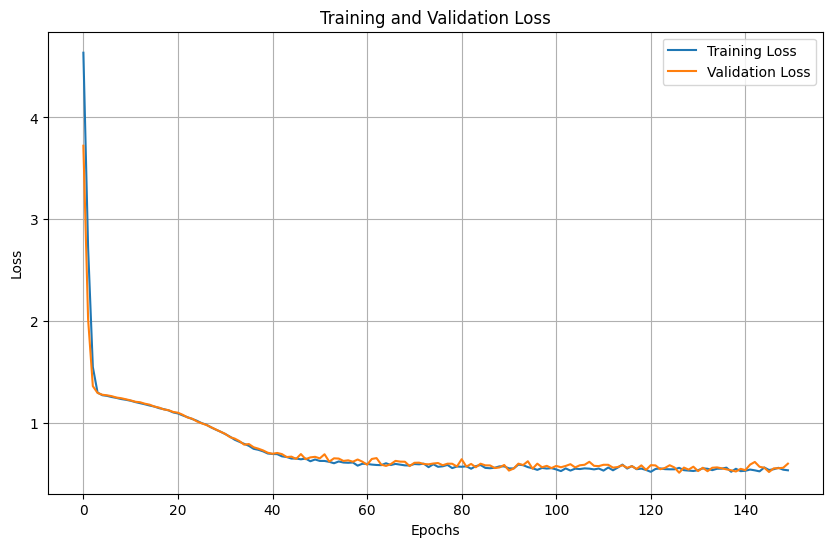

In [9]:
# Plot loss

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
# ax.set_xlim(20,150)
# ax.set_ylim(0.4, 0.8)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.grid()
ax.legend()
plt.show()

In [11]:
# Try with different model architecture

models = {}

# Try same architecture but with dropout layers
torch.manual_seed(42)
models['model1'] = nn.Sequential(nn.Linear(8, 40),
                                 nn.ReLU(),
                                 nn.Dropout(p = 0.2),
                                 nn.Linear(40, 120),
                                 nn.ReLU(),
                                 nn.Dropout(p = 0.2),
                                 nn.Linear(120, 40),
                                 nn.ReLU(),
                                 nn.Dropout(p = 0.2),
                                 nn.Linear(40, 1))

# Try a deeper network with more neurons per layer
torch.manual_seed(42)
models['model2'] = nn.Sequential(nn.Linear(8, 200),
                                 nn.ReLU(),
                                 nn.Linear(200, 500),
                                 nn.ReLU(),
                                 nn.Linear(500, 500),
                                 nn.ReLU(),
                                 nn.Linear(500, 200),
                                 nn.ReLU(),
                                 nn.Linear(200,200),
                                 nn.ReLU(),
                                 nn.Linear(200, 1))

# Try shallower network but with more neurons per layer
torch.manual_seed(42)
models['model3'] = nn.Sequential(nn.Linear(8, 500),
                                 nn.ReLU(),
                                 nn.Linear(500, 1000),
                                 nn.ReLU(),
                                 nn.Linear(1000, 500),
                                 nn.ReLU(),
                                 nn.Linear(500,1))

# Try deeper network with SiLU activation function
torch.manual_seed(42)
models['model4'] = nn.Sequential(nn.Linear(8, 64),
                                 nn.SiLU(),
                                 nn.Linear(64,256),
                                 nn.SiLU(),
                                 nn.Linear(256, 512),
                                 nn.SiLU(),
                                 nn.Linear(512,512),
                                 nn.SiLU(),
                                 nn.Linear(512, 256),
                                 nn.SiLU(),
                                 nn.Linear(256, 64),
                                 nn.SiLU(),
                                 nn.Linear(64, 1))

optimizers = {key : torch.optim.SGD(params = models[key].parameters(), lr = 0.001) for key in models.keys()}

In [12]:
# Train models
train_loss = {}
val_loss = {}

for key in models.keys():
    print('\n')
    print("Training with: ", key)
    train_loss[key], val_loss[key] = train(models[key], train_loader, val_loader, loss_fn, optimizers[key], 50)



Training with:  model1
Epoch 5/50 - Training Loss: 1.3423 - Validation Loss: 1.2761
Epoch 10/50 - Training Loss: 1.2852 - Validation Loss: 1.2235
Epoch 15/50 - Training Loss: 1.2376 - Validation Loss: 1.1776
Epoch 20/50 - Training Loss: 1.1858 - Validation Loss: 1.1198
Epoch 25/50 - Training Loss: 1.1111 - Validation Loss: 1.0452
Epoch 30/50 - Training Loss: 1.0392 - Validation Loss: 0.9517
Epoch 35/50 - Training Loss: 0.9536 - Validation Loss: 0.8564
Epoch 40/50 - Training Loss: 0.8897 - Validation Loss: 0.7574
Epoch 45/50 - Training Loss: 0.8475 - Validation Loss: 0.7050
Epoch 50/50 - Training Loss: 0.7877 - Validation Loss: 0.6815


Training with:  model2
Epoch 5/50 - Training Loss: 1.3482 - Validation Loss: 1.3316
Epoch 10/50 - Training Loss: 1.2930 - Validation Loss: 1.2954
Epoch 15/50 - Training Loss: 1.2524 - Validation Loss: 1.2602
Epoch 20/50 - Training Loss: 1.1932 - Validation Loss: 1.1952
Epoch 25/50 - Training Loss: 1.0818 - Validation Loss: 1.0785
Epoch 30/50 - Training

In [13]:
# Evaluate models

for key in models.keys():
    train_mse, train_r2 = evaluate(models[key], train_loader)
    val_mse, val_r2 = evaluate(models[key], val_loader)
    test_mse, test_r2 = evaluate(models[key], test_loader)

    print('\n')
    print("For", key)
    print(f'{key} - Training MSE: {train_mse:.4f} - Training R2: {train_r2:.4f}')
    print(f'{key} - Validation MSE: {val_mse:.4f} - Validation R2: {val_r2:.4f}')
    print(f'{key} - Test MSE: {test_mse:.4f} - Test R2: {test_r2:.4f}')



For model1
model1 - Training MSE: 0.6803 - Training R2: 0.4889
model1 - Validation MSE: 0.6527 - Validation R2: 0.5133
model1 - Test MSE: 0.6762 - Test R2: 0.4861


For model2
model2 - Training MSE: 0.5959 - Training R2: 0.5524
model2 - Validation MSE: 0.5994 - Validation R2: 0.5530
model2 - Test MSE: 0.6122 - Test R2: 0.5348


For model3
model3 - Training MSE: 0.5760 - Training R2: 0.5673
model3 - Validation MSE: 0.5274 - Validation R2: 0.6068
model3 - Test MSE: 0.5317 - Test R2: 0.5959


For model4
model4 - Training MSE: 1.3311 - Training R2: 0.0000
model4 - Validation MSE: 1.3413 - Validation R2: -0.0001
model4 - Test MSE: 1.3159 - Test R2: -0.0000


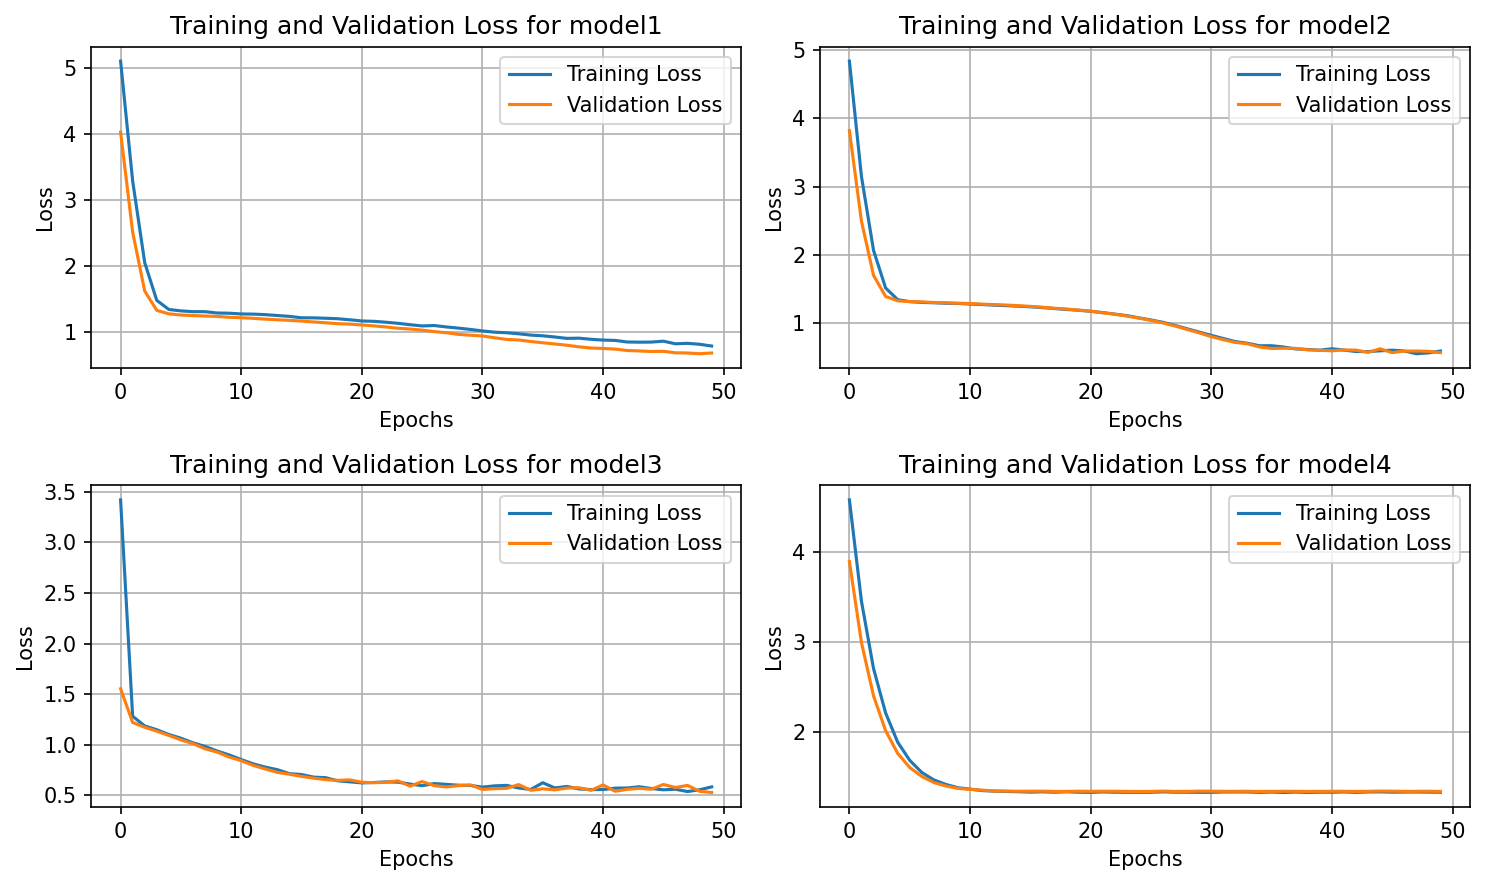

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), dpi = 150)

keys = list(models.keys())

for i in range(2):
    for j in range(2):
        key = keys[2*i + j]
        ax[i,j].plot(train_loss[key], label='Training Loss')
        ax[i,j].plot(val_loss[key], label='Validation Loss')
        ax[i,j].set_xlabel('Epochs')
        ax[i,j].set_ylabel('Loss')
        ax[i,j].set_title(f'Training and Validation Loss for {key}')
        ax[i,j].grid()
        ax[i,j].legend()

fig.tight_layout()